In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

In [2]:
# Read in Data
data538 = pd.read_csv('/Users/oliviacontratto/Desktop/nfl_elo.csv')

In [51]:
def get_post_elo(home_team, home_team_elo, away_team, away_team_elo, mov, decay, home_adv):
    
    if mov > 0:
        FD = 1 - get_win_prob(home_team_elo, away_team_elo, home_adv)
    else: FD = 0 - get_win_prob(home_team_elo, away_team_elo, home_adv)
    
    home_post_elo = get_k(mov, home_team_elo, away_team_elo, decay, home_adv)*FD  + home_team_elo
    away_post_elo = away_team_elo + (home_team_elo - home_post_elo)
    
    return home_post_elo, away_post_elo
    
def get_win_prob(home_team_elo, away_team_elo, hfa):
    home_team_elo += hfa
    return 1.0/(1.0+(10.0**((away_team_elo-home_team_elo)/400)))

def get_k(mov, team_elo, opp_elo, decay, HFA):
    
    if mov > 0: elo_dif = team_elo-opp_elo + HFA
    else: elo_dif = opp_elo-team_elo - HFA
    
    K = 20.0 * np.log(np.abs(mov)+1) * 2.2/(elo_dif*0.001+2.2)
    return K*decay

In [52]:
def train_k_decay(data, elos={}, season_start_epsilon=1.0, epsilon_decay=1.0, hfa=65):
    
    epsilon = season_start_epsilon
    elo_dict = {}

    val_dict_list = []
    test_dict_list = []

    # For Each Game
    for i in range(data.shape[0]):

        # Get Game Info
        row = data.iloc[i]
        team = row.team1
        opp = row.team2
        mov = row.score1 - row.score2

        # Seasonal ELO Adjustment for Every Team
        if i > 0 and row.season != data.iloc[i-1].season:
            for k in elo_dict.keys():
                elo_dict[k] = .66*elo_dict[k] + .33*1505

            # Reset Epsilon
            epsilon = season_start_epsilon

        # If team's first game, use 538's elo to start
        if team not in elo_dict.keys():
            elo_dict[team] = row['elo1_pre']
        if opp not in elo_dict.keys():
            elo_dict[opp] = row['elo2_pre']

        # Get Pre-Game ELO Estimates
        team_pre = elo_dict[team]
        opp_pre = elo_dict[opp]

        # Adjust Epsilon Every 25 Games
        if i % 25 == 0:
            epsilon *= epsilon_decay

        # Update ELOs based on game results    
        elo_dict[team], elo_dict[opp] = get_post_elo(team, team_pre, opp, opp_pre, mov, epsilon, hfa)
        
    return elo_dict

def k_decay_validation_dict(data, elos={}, season_start_epsilon=1.0, epsilon_decay=1.0, hfa=100):
    
    '''
    Inputs:
     - data: Set of games to validate the ELO model on
     - elos: set of trained elos
     - val_dfs: List of DataFrames that contain ELOs for every game
     - season_start_epsilon
     - epsilon_decay
     - hfa: Home Field Advantage adjustment
     
     Outputs:
      - Row for DataFrame of Total Loss and overall Prediction Accuracy, for every combination of hyperparameters
    
    '''
    
    elo_dict = elos
    val_dict_list = []
    epsilon = season_start_epsilon

    for i in range(data.shape[0]):
        
        row = data.iloc[i]
        team = row.team1
        opp = row.team2
        mov = row.score1 - row.score2

        # Seasonal ELO Adjustment for Every Team
        if i > 0 and row.season != data.iloc[i-1].season:
            for k in elo_dict.keys():
                elo_dict[k] = .66*elo_dict[k] + .33*1505

            # Reset Epsilon
            epsilon = season_start_epsilon

        # If team's first game, use 538's elo to start
        if team not in elo_dict.keys():
            elo_dict[team] = row['elo1_pre']
        if opp not in elo_dict.keys():
            elo_dict[opp] = row['elo2_pre']

        # Get Pre-Game ELO Estimates
        team_pre = elo_dict[team]
        opp_pre = elo_dict[opp]

        # Adjust Epsilon Every 25 Games
        if i % 25 == 0:
            epsilon *= epsilon_decay

        # Update ELOs based on game results    
        elo_dict[team], elo_dict[opp] = get_post_elo(team, team_pre, opp, opp_pre, mov, epsilon, hfa)
        
        # Build DataFrame with Post-Game ELOs
        team_post = elo_dict[team]
        opp_post = elo_dict[opp]
        val_dict_list.append({'team1': team, 'team2': opp, 'team1_pre': team_pre, 'team2_pre': opp_pre, 'team1_post': team_post, 'team2_post': opp_post, 'MOV': mov})

    # New DataFrame of Elos Over Games in Validation Set
    val_df = pd.DataFrame(val_dict_list)
    
    preds = []
    losses = []
    outcomes = []

    # For Each Game in Validation Set
    for i in range(val_df.shape[0]):

        # Get Game Info
        row = val_df.iloc[i]
        mov = row.MOV 
        team_elo = row['team1_pre']
        opp_elo = row['team2_pre']

        # Get Predictions, Loss, and Results
        preds.append(get_win_prob(team_elo, opp_elo, hfa) > .5)
        losses.append(np.log(get_win_prob(team_elo, opp_elo, hfa) if mov > 0 else 1 - get_win_prob(team_elo, opp_elo, hfa)))
        outcomes.append(mov > 0)

    # True if Success, Otherwise False
    success_list = [preds[j] == outcomes[j] for j in range(len(preds))]

    # Make Row for DataFrame of Validation Results w/ Loss as accuracy
    return {'total_loss': np.sum(losses), 'accuracy': np.mean(success_list), 'season_start_ep': season_start_epsilon, 'epsilon_decay': epsilon_decay, 'HFA': hfa}

def test_model_dict(pre_data, data, elos={}, season_start_epsilon=1.0, epsilon_decay=1.0, hfa=100):
    '''
    Inputs: All the model stuff
    Outputs: Dictionary with model accuracy and total loss
    '''
    
    new_elos = train_k_decay(pre_data, {}, season_start_epsilon, epsilon_decay, hfa)
    
    return k_decay_validation_dict(data, new_elos, season_start_epsilon, epsilon_decay, hfa)

def fivethirtyeight_results_dict(data):
    
    # Get Predictions
    elo_preds = [get_win_prob(team_elo, opp_elo, 65) > .5 for team_elo, opp_elo in zip(data['elo1_pre'], data['elo2_pre'])]
    
    # Get Outcomes
    outcomes = [s1 > s2 for s1, s2 in zip(data['score1'], data['score2'])]
    
    # Get Success Rates
    elo_acc = np.mean([elo_preds[j] == outcomes[j] for j in range(len(elo_preds))])
                
    # Get Losses
    data['win_prob'] = [get_win_prob(elo1, elo2, 65) for elo1, elo2 in zip(data['elo1_pre'], data['elo2_pre'])]            
    elo_loss = np.sum([np.log(prob if outcome == 1 else 1 - prob) for prob, outcome in zip(data['win_prob'], outcomes)])
                
    return {'total_loss_538': elo_loss, 'accuracy_538': elo_acc, 'season_start_ep': 1, 'epsilon_decay': 1, 'HFA': 65}

def k_decay_elo_list(data, season_start_epsilon, epsilon_decay, hfa):
    
    elo1_list = []
    elo2_list = []
    
    epsilon = season_start_epsilon
    elo_dict = {}

    val_dict_list = []
    test_dict_list = []

    # For Each Game
    for i in range(data.shape[0]):

        # Get Game Info
        row = data.iloc[i]
        team = row.team1
        opp = row.team2
        mov = row.score1 - row.score2

        # Seasonal ELO Adjustment for Every Team
        if i > 0 and row.season != data.iloc[i-1].season:
            for k in elo_dict.keys():
                elo_dict[k] = .66*elo_dict[k] + .33*1505

            # Reset Epsilon
            epsilon = season_start_epsilon

        # If team's first game, use 538's elo to start
        if team not in elo_dict.keys():
            elo_dict[team] = row['elo1_pre']
        if opp not in elo_dict.keys():
            elo_dict[opp] = row['elo2_pre']

        # Get Pre-Game ELO Estimates
        team_pre = elo_dict[team]
        opp_pre = elo_dict[opp]
        
        # Add Elos to List
        elo1_list.append(team_pre)
        elo2_list.append(opp_pre)

        # Adjust Epsilon Every 25 Games
        if i % 25 == 0:
            epsilon *= epsilon_decay

        # Update ELOs based on game results    
        elo_dict[team], elo_dict[opp] = get_post_elo(team, team_pre, opp, opp_pre, mov, epsilon, hfa)
        
    return (elo1_list, elo2_list)

def get_quantile(l, q):
    return sorted(l)[int(np.ceil((len(l)-1)*q))]

In [65]:
# Training, Validation, and Test Sets

START_YEAR = 2004
VALIDATION_START_YEAR = 2011
TEST_START_YEAR = 2012

train_games = data538[data538['season'] >= START_YEAR]
train_games = train_games[train_games['season'] < VALIDATION_START_YEAR]

validation_games = data538[data538['season'] >= VALIDATION_START_YEAR]
validation_games = validation_games[validation_games['season'] < TEST_START_YEAR]

pre_test_games = data538[data538['season'] >= START_YEAR]
pre_test_games = pre_test_games[pre_test_games['season'] < TEST_START_YEAR]

test_games = data538[data538['season'] >= TEST_START_YEAR]
test_games = test_games[test_games['season'] < 2019]

In [66]:
# Hyperparameters to Tune
from hyperopt import hp
from hyperopt import tpe
from hyperopt import fmin
from hyperopt import Trials
from hyperopt import STATUS_OK

# Trials object to track progress
bayes_trials = Trials()

# Algorithm
tpe_algorithm = tpe.suggest

# Define Search Space
space = {
    'season_start_epsilon': hp.uniform('season_start_epsilon', .7, 1.8),
    'epsilon_decay': hp.uniform('epsilon_decay', .5, 1.5),
    'hfa': hp.quniform('h', 20, 110, 1)
}

MAX_EVALS = 400
accuracy_metric = 'total_loss' # or 'accuracy' for pure game prediction

def objective(params):
    
    start_ep = params['season_start_epsilon']
    ep_decay = params['epsilon_decay']
    h = params['hfa']
    
    new_elos = train_k_decay(train_games, elos={}, season_start_epsilon=start_ep, epsilon_decay=ep_decay, hfa=h)
    dic = k_decay_validation_dict(test_games, elos=new_elos, season_start_epsilon=start_ep, epsilon_decay=ep_decay, hfa=h)
    new_dic = {'loss': -1*dic[accuracy_metric], 'season_start_epsilon': start_ep, 'epsilon_decay': ep_decay, 'hfa': h, 'status': STATUS_OK}
    return new_dic

# Optimize
best = fmin(fn = objective, space = space, algo = tpe.suggest, 
            max_evals = MAX_EVALS, trials = bayes_trials)

best

  0%|          | 0/400 [00:00<?, ?it/s, best loss: ?]

/Users/oliviacontratto/Applications/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  

/Users/oliviacontratto/Applications/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:120: RuntimeWarning: divide by zero encountered in log



100%|██████████| 400/400 [10:25<00:00,  1.56s/it, best loss: 1174.5022439123754]


{'epsilon_decay': 0.98625487841995219,
 'h': 57.0,
 'season_start_epsilon': 1.0614309248097533}

In [69]:
print("season_start_k_multiplier:", np.round(best['season_start_epsilon'], 4))
print("k_decay_rate:", np.round(best['epsilon_decay'], 4))
print("HFA:", best['h'])

season_start_k_multiplier: 1.0614
k_decay_rate: 0.9863
HFA: 57.0


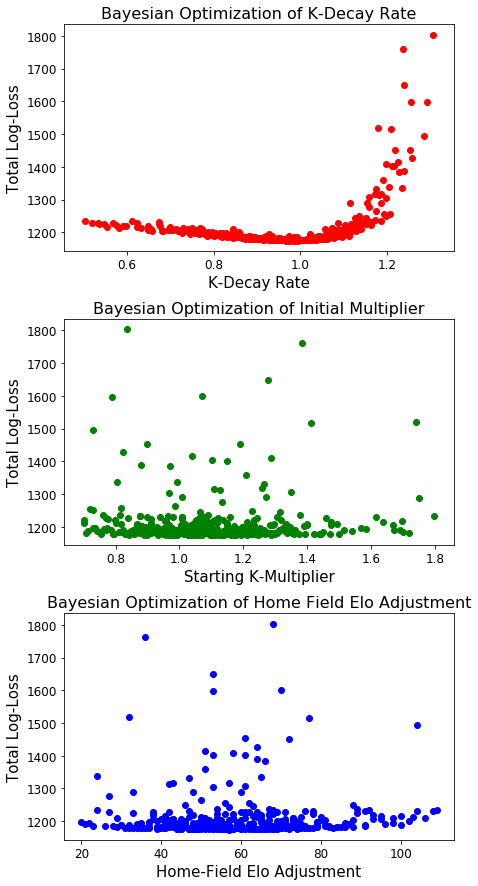

In [70]:
# Show Trial Loss Over Time
trials = list(bayes_trials)
losses = []
hfas = []
start_eps = []
ep_decs = []

for trial in trials:
    result = trial['result']
    if result['loss'] < 11000:
        losses.append(result['loss'])
        hfas.append(result['hfa'])
        start_eps.append(result['season_start_epsilon'])
        ep_decs.append(result['epsilon_decay'])
    
fig, axes = plt.subplots(3,1,figsize=(7,15))
fig.subplots_adjust(hspace=.3)

for ax in axes:
    ax.set_ylabel('Total Log-Loss', fontsize=15)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(12) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(12) 

axes[0].scatter(ep_decs, losses, color='r')
axes[0].set_xlabel('K-Decay Rate', fontsize=15)
axes[0].set_title('Bayesian Optimization of K-Decay Rate', fontsize=16)

axes[1].scatter(start_eps, losses, color='g')
axes[1].set_xlabel('Starting K-Multiplier', fontsize=15)
axes[1].set_title('Bayesian Optimization of Initial Multiplier', fontsize=16)

axes[2].scatter(hfas, losses, color='b')
axes[2].set_xlabel('Home-Field Elo Adjustment', fontsize=15)
axes[2].set_title('Bayesian Optimization of Home Field Elo Adjustment', fontsize=16)

plt.savefig('bayes_opt2.png')
plt.show()

In [71]:
# Get Accuracy for the 'Best' Model Hyperparameters
start_ep = best['season_start_epsilon']
ep_decay = best['epsilon_decay']
h = best['h']

old_model_start_ep = 1.403857708071705
old_model_ep_decay = 0.9362537924997516
old_model_hfa = 88.0

#start_ep = old_model_start_ep
#ep_decay = old_model_ep_decay
#h = old_model_hfa

new_elos = train_k_decay(train_games, elos={}, season_start_epsilon=start_ep, epsilon_decay=ep_decay, hfa=h)
k_decay_validation_dict(test_games, elos=new_elos, season_start_epsilon=start_ep, epsilon_decay=ep_decay, hfa=h)

{'HFA': 57.0,
 'accuracy': 0.6468699839486356,
 'epsilon_decay': 0.98625487841995219,
 'season_start_ep': 1.0614309248097533,
 'total_loss': -1174.5022439123754}

In [72]:
fivethirtyeight_results_dict(test_games)

{'HFA': 65,
 'accuracy_538': 0.64954521134296417,
 'epsilon_decay': 1,
 'season_start_ep': 1,
 'total_loss_538': -1168.8699422573382}

In [73]:
# Get List of Elos
df = data538[data538['season']>=TEST_START_YEAR]
df = df[df['season']<2019]

l1, l2 = k_decay_elo_list(df, start_ep, ep_decay, h)
df['k_decay_elo1'] = l1
df['k_decay_elo2'] = l2

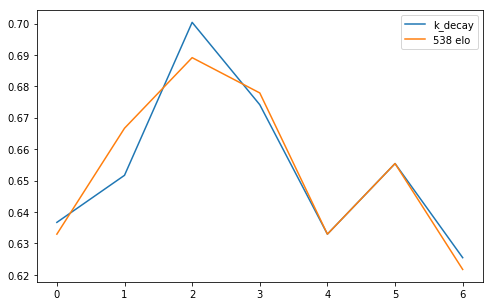

In [74]:
elo_preds = []
elo_538_preds = []
elo_accs = []
elo_538_accs = []

for year in df.season.unique():

    # Trim to the Given Season
    trim = df[df['season']==year]
    
    # Get Predictions
    elo_preds = [get_win_prob(team_elo, opp_elo, h) > .5 for team_elo, opp_elo in zip(trim['k_decay_elo1'], trim['k_decay_elo2'])]
    elo_538_preds = [get_win_prob(team_elo, opp_elo, h) > .5 for team_elo, opp_elo in zip(trim['elo1_pre'], trim['elo2_pre'])]
    
    # Get Outcomes
    outcomes = [s1 > s2 for s1, s2 in zip(trim['score1'], trim['score2'])]
    
    # Get Success Rates
    elo_accs.append(np.mean([elo_preds[j] == outcomes[j] for j in range(len(elo_preds))]))
    elo_538_accs.append(np.mean([elo_538_preds[j] == outcomes[j] for j in range(len(elo_538_preds))]))
    
fig, ax = plt.subplots(1,1,figsize=(8,5))

ax.plot(elo_accs, label='k_decay')
ax.plot(elo_538_accs, label='538 elo')

ax.legend()
plt.show()

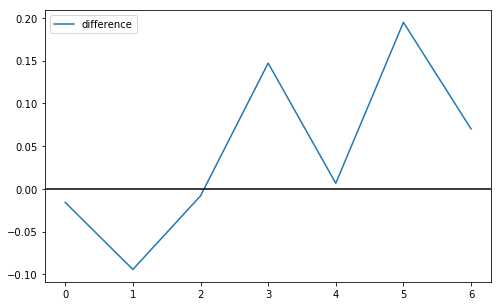

In [84]:
elo_538_preds = []
all_elo_losses = []
all_elo_538_losses = []
elo_losses = []
elo_538_losses = []

for year in df.season.unique():
    
    # Trim to the Given Season
    trim = df[df['season']==year]
    
    # Get Predictions
    elo_preds = [get_win_prob(team_elo, opp_elo, h) for team_elo, opp_elo in zip(trim['k_decay_elo1'], trim['k_decay_elo2'])]
    elo_538_preds = [get_win_prob(team_elo, opp_elo, h) for team_elo, opp_elo in zip(trim['elo1_pre'], trim['elo2_pre'])]
    
    # Get Outcomes
    outcomes = [s1 > s2 for s1, s2 in zip(trim['score1'], trim['score2'])]
    
    # Get Success Rates
    elo_losses.append(np.sum([np.log(get_win_prob(team_elo, opp_elo, h) if outcome == 1 else 1 - get_win_prob(team_elo, opp_elo, h)) for outcome, team_elo, opp_elo in zip(outcomes, trim['k_decay_elo1'], trim['k_decay_elo2'])]))
    elo_538_losses.append(np.sum([np.log(get_win_prob(team_elo, opp_elo, h) if outcome == 1 else 1 - get_win_prob(team_elo, opp_elo, h)) for outcome, team_elo, opp_elo in zip(outcomes, trim['elo1_pre'], trim['elo2_pre'])]))    

difs = [elo_losses[i] - elo_538_losses[i] for i in range(len(elo_losses))]

fig, ax = plt.subplots(1,1,figsize=(8,5))

ax.plot(difs, label='difference')

ax.axhline(y=0, color='k')

ax.legend()
plt.show()

In [76]:
print(np.sum(elo_losses[-5:]))
print(np.sum(elo_538_losses[-5:]))

-833.760379688
-834.170752032


In [77]:
# Bootstrap Elo Losses
elo_losses = []
elo_538_losses = []
loss_upper = []
loss_list = []
loss_lower = []

for year in df.season.unique():
    
    # Trim to the Given Season
    trim = df[df['season']==year]
    
    win_probs = [get_win_prob(team_elo, opp_elo, h) for team_elo, opp_elo in zip(trim['k_decay_elo1'], trim['k_decay_elo2'])]
    win_probs_538 = [get_win_prob(team_elo, opp_elo, h) for team_elo, opp_elo in zip(trim['elo1_pre'], trim['elo2_pre'])]
    
    # Get Outcomes
    outcomes = [s1 > s2 for s1, s2 in zip(trim['score1'], trim['score2'])]
    
    # Get Predictions
    elo_losses = [np.log(prob if outcome == 1 else 1 - prob) for prob, outcome in zip(win_probs, outcomes)]
    elo_538_losses = [np.log(prob if outcome == 1 else 1 - prob) for prob, outcome in zip(win_probs_538, outcomes)]
    
    # Record Loss Difference
    loss_list.append(np.sum(elo_losses)-np.sum(elo_538_losses))
    
    # BootStrap
    
    bs_loss_dif_list = []
    
    for n in range(5000):
        # Bootstrap Sample
        indices = np.random.choice([i for i in range(len(elo_losses))], size=len(elo_losses), replace=True)

        # Get Total Loss Difference for Bootstrap Sample
        bs_elo_losses = [elo_losses[index] for index in indices]
        bs_elo_losses_538 = [elo_538_losses[index] for index in indices]
        
        bs_loss_dif_list.append(np.sum(bs_elo_losses) - np.sum(bs_elo_losses_538))
        
    loss_upper.append(get_quantile(bs_loss_dif_list, .975))
    loss_lower.append(get_quantile(bs_loss_dif_list, .025))

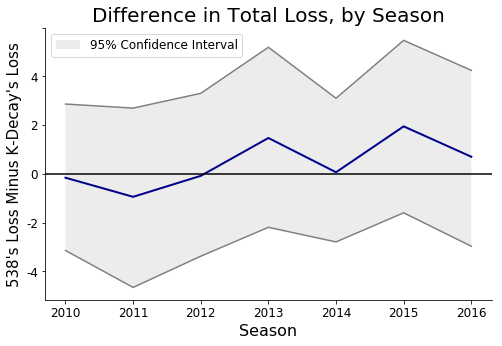

In [85]:
fig, ax = plt.subplots(1,1,figsize=(8,5))

ax.plot(loss_list, color='darkblue', linewidth=2.0)
ax.plot(loss_upper, color='grey')
ax.plot(loss_lower, color='grey')

ax.fill_between(range(len(loss_list)), loss_list, loss_lower, facecolor='gray', alpha=0.15, label='95% Confidence Interval')
ax.fill_between(range(len(loss_list)), loss_list, loss_upper, facecolor='gray', alpha=0.15)

ax.set_xticklabels(range(2009, 2019), fontsize=12)
ax.set_yticklabels(range(-6, 5, 2), fontsize=12)

ax.set_xlabel('Season', fontsize=16)
ax.set_ylabel("538's Loss Minus K-Decay's Loss", fontsize=15)
ax.set_title('Difference in Total Loss, by Season', fontsize=20)

ax.axhline(y=0, color='black')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#ax.grid()
ax.legend(fontsize=12)
plt.savefig('Loss_Difference_Intervals.png')
plt.show()

In [79]:
np.sum(elo_losses)

-169.05438674836006

In [80]:
np.sum(elo_538_losses)

-169.12450595063544